In [1]:
from tensorflow.keras.datasets import reuters
import pandas as pd
import numpy as np
import time

import os
from dotenv import load_dotenv

In [2]:
path = "./data/"

In [3]:
ls data

1.crypto_apps_reviews_raw.csv         co.mona.android.csv
2.crypto_app_reviews_tagged.csv       com.binance.dev.csv
2.crypto_category.txt                 com.bybit.app.csv
3.tagged_reviews_sample.csv           crypt_app_llm_tagged.csv
4.tagged_reviews_sample_verified.csv  crypto_app_llm_tagged.csv


In [113]:
df = pd.read_csv(path+"/4.tagged_reviews_sample_verified.csv")

In [330]:
hold_out_index = df["app"]== "com.binance.dev"

In [358]:
df_r = df.sample(df.shape[0] * 100, replace=True)

In [359]:
df_r.columns

Index(['reviewId', 'userName', 'userImage', 'content', 'score',
       'thumbsUpCount', 'reviewCreatedVersion', 'at', 'replyContent',
       'repliedAt', 'appVersion', 'app', 'gemini_llm_topic', 'correct',
       'human_labeled_topic', 'cause'],
      dtype='object')

In [360]:
df_r["gemini_llm_topic"].value_counts()

gemini_llm_topic
Usability/UI/UX                     3660
Reliability/Stability               3478
Account Management                  3128
Customer Support                    2947
Transaction Fees/Speed              2720
Generic feedback                    2074
Verification/KYC/AML Processes      1368
Features/Functionality               724
Security                             407
Educational Resources/Onboarding     404
Privacy                               97
Wallet Security/Integration           93
Name: count, dtype: int64

## Preprocessing

In [361]:
from collections import Counter
import spacy
import string
import nltk

In [362]:
nlp = spacy.load('en_core_web_sm')
#nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words("english")
stemmer = nltk.stem.PorterStemmer()

In [363]:
unwanted_pipes = ['ner', 'parser']

# Further remove stop words and take the lemma instead of token text.
def spacy_tokenizer(doc):
    with nlp.disable_pipes(*unwanted_pipes):
        return [t.lemma_ for t in nlp(doc) if \
            not t.is_punct and \
            not t.is_space and \
            not t.is_stop and \
            t.is_alpha] #only consider alphanumeric character

def nltk_tokenizer(doc):
    doc = doc.strip()
    doc = doc.lower()
    tokens = nltk.word_tokenize(doc)
    return [stemmer.stem(t) for t in tokens if \
        t not in string.punctuation and \
        t not in stopwords ] #only consider alphanumeric character

In [364]:
df_r["content_preprocessed"] = df_r["content"].apply(lambda x: " ".join(nltk_tokenizer(x)))

In [365]:
df_r = df_r.reset_index()

In [366]:
corpus_raw = []
corpus_lower = []
corpus_preprocessed = []
for i in range(df_r.shape[0]):
    corpus_raw.extend(df_r["content"][i].strip().split())
    corpus_lower.extend(df_r["content"][i].lower().strip().split())
    corpus_preprocessed.extend(df_r["content_preprocessed"][i].split())
    

In [367]:
counter_raw = Counter(corpus_raw)
counter_lower = Counter(corpus_lower)
counter_preprocessed = Counter(corpus_preprocessed)

In [368]:
counter_preprocessed.most_common(30)

[("n't", 11673),
 ('app', 11306),
 ("'s", 6488),
 ('use', 5546),
 ('account', 4735),
 ('get', 4295),
 ('money', 4292),
 ('crypto', 3893),
 ('updat', 3810),
 ('custom', 3116),
 ('card', 3083),
 ('ca', 3076),
 ('fee', 2995),
 ('work', 2920),
 ('servic', 2874),
 ('trade', 2808),
 ('bybit', 2728),
 ('tri', 2665),
 ('coin', 2417),
 ('time', 2367),
 ('exchang', 2324),
 ("'m", 2255),
 ('pleas', 2203),
 ('support', 2188),
 ('...', 2059),
 ('take', 2052),
 ('one', 2049),
 ('scam', 2001),
 ('need', 1898),
 ('good', 1879)]

In [369]:
30/len(counter_lower)

0.015259409969481181

In [370]:
counter_preprocessed.most_common(30)[1][1]/len(counter_preprocessed)

9.646757679180887

In [371]:
top_sum_raw = 0
top_sum_lower = 0
top_sum_preprocessed = 0

top_n = 30
for i in range(top_n):
    top_sum_raw += counter_raw.most_common(top_n)[i][1]
    top_sum_lower += counter_lower.most_common(top_n)[i][1]
    top_sum_preprocessed += counter_preprocessed.most_common(top_n)[i][1]
print(f"""
    Unique words for raw text:{len(counter_raw)}.
    Percentage of tokens concentrated in the top {top_n} words:{100*top_sum_raw / counter_raw.total()}
    """)

print(f"""
    Unique words for lower case text:{len(counter_lower)}.
    Percentage of tokens concentrated in the top {top_n} words:{100*top_sum_lower / counter_lower.total()}
    """)

print(f"""
    Unique words for Preprocessed text:{len(counter_preprocessed)}.
    Percentage of tokens concentrated in the top {top_n} words:{100*top_sum_preprocessed / counter_preprocessed.total()}
    """)


    Unique words for raw text:2205.
    Percentage of tokens concentrated in the top 30 words:31.138805340300344
    

    Unique words for lower case text:1966.
    Percentage of tokens concentrated in the top 30 words:33.92359403180849
    

    Unique words for Preprocessed text:1172.
    Percentage of tokens concentrated in the top 30 words:25.4860870201373
    


Why preprocess:
* Reduce number of tokens.
* Remove words that are very generic (the, 

# check: https://colab.research.google.com/drive/1y8tnFKQ_mW4CA0McZ-HJJoeheRL2j265
take the lemma: example of comments "Pi not listed", "They dont list pi", ideally we extract only "list"

## Train test split

In [372]:
from sklearn.model_selection import train_test_split

In [373]:
df_r.shape

(21100, 18)

In [374]:
X = df_r
y = df_r.gemini_llm_topic

In [375]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42)


#split text and labels
train_sentences = X_train.content_preprocessed.to_numpy()
train_labels = X_train.gemini_llm_topic.to_numpy()
test_sentences = X_test.content_preprocessed.to_numpy()
test_labels = y_test.to_numpy()

In [376]:
test_sentences.size

4220

## Tokenize

In [377]:
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import OneHotEncoder

In [378]:
from collections import Counter

In [379]:
num_unique_words = len(counter_preprocessed)
print(num_unique_words)

1172


In [380]:
#vectorize a text corpus by turning each text into a sequence of integers
tokenizer = Tokenizer(num_words=num_unique_words)
tokenizer.fit_on_texts(train_sentences) #fit only to trainin

In [381]:
len(train_sentences)

16880

In [382]:
#vectorize the labels
le = LabelEncoder()
#le = OneHotEncoder()
le.fit(df_r["gemini_llm_topic"]) #fit only to trainin

LabelEncoder()

In [383]:
#each word has a unique index
word_index = tokenizer.word_index

In [384]:
train_sequences = tokenizer.texts_to_sequences(train_sentences)
test_sequences = tokenizer.texts_to_sequences(test_sentences)

In [385]:
y_train = le.transform(train_labels)
y_test = le.transform(test_labels)

In [386]:
print("Example sequence 1:")
print(f"Example sequence 2. Label: {y_train[10]}")
print(train_sentences[10])
print(train_sequences[10])
print(f"Example sequence 2. Label: {y_train[11]}")
print(train_sentences[11])
print(train_sequences[11])

Example sequence 1:
Example sequence 2. Label: 0
pleas 's difficult login account
[23, 3, 289, 229, 5]
Example sequence 2. Label: 9
'm lock buy crypto ca n't enter cvv card number name expir date 've tri multipl card use time `` support specialist '' said area gray would enter info confirm told said bank problem use differ card differ bank said 's app problem bc place 'm experienc issu could n't explain card info could n't enter
[22, 57, 35, 8, 12, 1, 182, 939, 11, 142, 282, 940, 372, 34, 18, 153, 11, 4, 19, 24, 467, 32, 188, 941, 942, 95, 182, 331, 943, 265, 188, 53, 107, 4, 139, 11, 139, 53, 188, 3, 2, 107, 944, 198, 22, 945, 43, 41, 1, 946, 11, 331, 41, 1, 182]


As seen above, sequences can have different lengths since the sentences may contain a distinct number of words. We need all sequences to be of the same length, and for this we will use padding.

In [387]:
#Pad the sequences to have the same length
from tensorflow.keras.preprocessing.sequence import pad_sequences

#max number of words in a sequence
max_length = 255

train_padded = pad_sequences(train_sequences, maxlen= max_length, padding = "post", truncating = "post")
test_padded = pad_sequences(test_sequences, maxlen = max_length, padding = "post", truncating = "post")
train_padded.shape, test_padded.shape

((16880, 255), (4220, 255))

In [388]:
reverse_word_index = dict([(idx, word) for (word, idx) in word_index.items()])

In [389]:
def decode(sequence):
    return " ".join([reverse_word_index.get(idx, "?") for idx in sequence])

In [390]:
decoded_text = decode(train_sequences[10])

In [391]:
decoded_text

"pleas 's difficult login account"

## Train model

In [392]:
num_classes = df_r["gemini_llm_topic"].nunique()

In [393]:
num_classes

12

In [394]:
df_r["gemini_llm_topic"].value_counts()

gemini_llm_topic
Usability/UI/UX                     3660
Reliability/Stability               3478
Account Management                  3128
Customer Support                    2947
Transaction Fees/Speed              2720
Generic feedback                    2074
Verification/KYC/AML Processes      1368
Features/Functionality               724
Security                             407
Educational Resources/Onboarding     404
Privacy                               97
Wallet Security/Integration           93
Name: count, dtype: int64

In [395]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers

In [396]:
model = keras.Sequential([
layers.Dense(num_classes*20, 
             kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001), 
             #kernel_regularizer=regularizers.l2(0.002), 
             activation="relu"),
    
    layers.Dropout(0.3),
layers.Dense(num_classes*20, 
             kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001), 
             #kernel_regularizer=regularizers.l2(0.002), 
             activation="relu"),
    
    layers.Dropout(0.3),
layers.Dense(num_classes*20, 
             kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001), 
             #kernel_regularizer=regularizers.l2(0.002), 
             activation="relu"),
    
    #layers.Dropout(0.3),
    #layers.Dense(num_classes, activation="softmax")
])

desc_length = df_r["content_preprocessed"].apply(lambda x: len(x) )
max_length = max(desc_length)
model = keras.Sequential()
model.add(layers.Embedding(len(counter_preprocessed), 32))

model.add(layers.LSTM(64, dropout=0.1))
model.summary()

## Compile the model

In [397]:
#loss and optimizer
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optim = keras.optimizers.Adam(learning_rate=0.001)
metrics  = ["accuracy"]

In [398]:
model.compile(optimizer=optim, loss=loss, metrics=metrics)

In [399]:
#model.compile(optimizer="rmsprop",
#loss="sparse_categorical_crossentropy",
#metrics=["accuracy"])

In [400]:
len(train_padded)

16880

In [401]:
#validation set
x_val = train_padded[:50]
partial_x_train = train_padded[50:]
y_val = y_train[:50]
partial_y_train = y_train[50:]

In [402]:
history = model.fit(train_padded,
    y_train,
    epochs=100,
    batch_size=512,
    validation_split=0.7)

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.0770 - loss: 97.6330 - val_accuracy: 0.3610 - val_loss: 23.0700
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2999 - loss: 33.0051 - val_accuracy: 0.5685 - val_loss: 12.9857
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4134 - loss: 19.8537 - val_accuracy: 0.6427 - val_loss: 10.2771
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4728 - loss: 14.2105 - val_accuracy: 0.7982 - val_loss: 8.8976
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5466 - loss: 11.6683 - val_accuracy: 0.8179 - val_loss: 8.1981
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6025 - loss: 10.2007 - val_accuracy: 0.8461 - val_loss: 7.6707
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6400 - loss: 9.1576 - val_accuracy: 0.8674 - val_loss: 7.2331
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6671 - loss: 8.4345 - val_acc

In [403]:
#!pip install matplotlib

In [404]:
import matplotlib.pyplot as plt

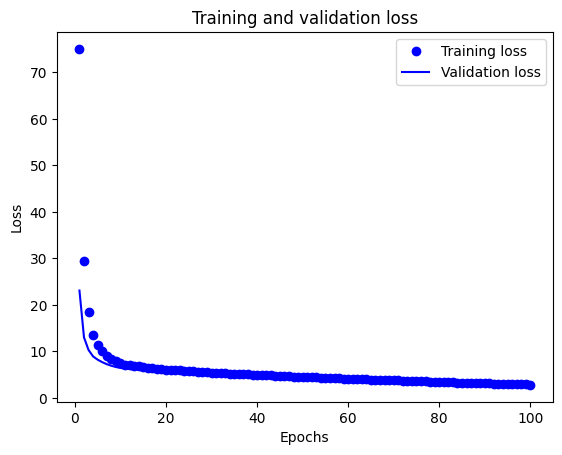

In [405]:
#plotting the training and validation loss
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [406]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [407]:
train_metric = 'accuracy'
val_metric = 'val_accuracy'

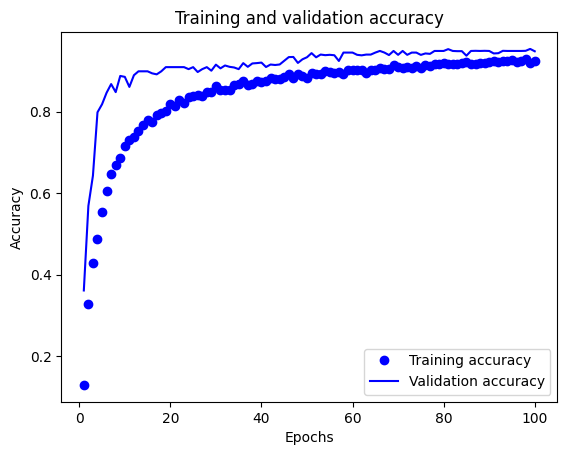

In [408]:
#plotting the training and validation accuracy
plt.clf()
acc = history.history[train_metric]
val_acc = history.history[val_metric]
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [409]:
model.evaluate(test_padded, y_test)

132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step - accuracy: 0.9475 - loss: 2.7777


[2.7815005779266357, 0.9452606439590454]

In [410]:
y_test

array([9, 6, 1, ..., 1, 4, 9])

In [411]:
predictions = model.predict(test_padded)

132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 616us/step


In [412]:
predictions[3]

array([2.0369570e+01, 3.4844433e+01, 9.5990648e+00, 1.7004210e+01,
       5.9238491e+00, 2.4233370e+00, 1.3678977e+01, 6.8866425e+00,
       1.1925764e+01, 1.1441545e+01, 2.0665798e+01, 4.5991688e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 7.1538270e-01,
       4.0486836e-01, 0.0000000e+00, 3.0373341e-01, 4.2477041e-01,
       0.0000000e+00, 3.4766284e-01, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       1.8205481e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 8.3151066e-01,
       2.8605098e-01, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 3.2158446e+00, 4.2502177e-01, 1.6540256e-01,
       0.0000000e+00, 1.1337155e+00, 0.0000000e+00, 8.7028944e-01,
       3.2176584e-01, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 5.3235114e-01, 0.0000000e+00,
       7.5118297e-01, 1.3795748e+00, 0.0000000e+00, 1.5414035e

In [413]:
pred_list = []
for p in predictions:
   pred_list.append(p.argmax())

In [414]:
from sklearn.metrics import f1_score

In [415]:
f1_score(y_test, pred_list, average='micro')

0.945260663507109

In [416]:
qa_df = pd.DataFrame({"text":X_test.content.to_numpy(), 
              "true_value":le.inverse_transform(y_test), 
              "predicted_value": le.inverse_transform(pred_list)})

In [420]:
dup_index = qa_df.duplicated()
qa_df = qa_df[~dup_index].copy()

In [421]:
for row in qa_df.to_dict(orient="records"):
    if row["predicted_value"]!= "generic feedback":
        print(row["text"])
        print("True value:",row["true_value"])
        print("Predicted value:", row["predicted_value"])
        print("***********************")

I'm locked out of buying crypto, I can't enter the CVV or CARD NUMBER, only my name and expiration dates. I've tried multiple cards, that I use all of the time and the "support specialist" said that the areas were gray where I would enter info, confirming what I told them. They said it was a bank problem but I used different cards from different banks. I said it's an APP problem bc this is the only place I'm experiencing this issue. They couldn't explain why my card info couldn't be entered.
True value: Usability/UI/UX
Predicted value: Usability/UI/UX
***********************
I don't understand bybit all the uprise in btc and other crypto currencies don't affect bybit that's really bad you see other exchange binace remitano you see a good change in it when it comes to bybit there is little or no difference at all you guys should really work on this cause most users are starting to notice
True value: Reliability/Stability
Predicted value: Reliability/Stability
***********************
Ple

## Predicting against holdout set